# Examples of plots and calculations using the tmm and colorpy package

This example uses tmm and colorpy package to calculate the surface of stacked layers.

Note that ```tmm``` and ```colorpy``` packages are slightly altered from their original version. To successfully run this script, you have to download them from the following github repo:

- colorpy: https://github.com/kanhua/ColorPy

## Imports

In [1]:
from __future__ import division, print_function, absolute_import

In [2]:
%load_ext autoreload
%autoreload 2


from pypvcell.tmm_core import (coh_tmm, unpolarized_RT, ellips, absorp_in_each_layer,
                       position_resolved, find_in_structure_with_inf)

from numpy import pi, linspace, inf, array
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from pypvcell.transfer_matrix_optics import get_ntotal_fn
%matplotlib inline

## Set up

In [3]:
try:
    import colorpy.illuminants
    import colorpy.colormodels
    import colorpy.plots
    from pypvcell import color
    colors_were_imported = True
except ImportError:
    # without colorpy, you can't run sample5(), but everything else is fine.
    colors_were_imported = False


# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = pi/180

In [4]:
import colorpy.illuminants
import colorpy.colormodels
import colorpy.plots

In [5]:
if not colors_were_imported:
    print('Colorpy was not detected (or perhaps an error occurred when',
          'loading it). You cannot do color calculations, sorry!',
          'http://pypi.python.org/pypi/colorpy')
else:
    print("Colorpy is successfully installed.")

Colorpy is successfully installed.


In [6]:
from pypvcell import color

In [7]:
def hsvc_from_rgb(rgb):
    
    r=rgb[0]
    g=rgb[1]
    b=rgb[2]
    
    arg_M=np.argmax(rgb)
    arg_m=np.argmin(rgb)
    M=rgb[arg_M]
    m=rgb[arg_m]
    C=M-m
    
    if C==0:
        H=np.nan
    
    elif arg_M==0:
        H=np.mod(float(g-b)/float(C),6.0)
    
    elif arg_M==1:
        H=float(b-r)/float(C)+2
        
    elif arg_M==2:
        H=float(r-g)/float(C)+4
    H*=60
    
    V=M
    
    if V==0:
        S=0
    else:
        S=C/V
    
    return np.array([H,S,V,C])

def chroma_from_irgb(irgb):
    
    rgb=colorpy.colormodels.rgb_from_irgb(irgb)
    arg_M=np.argmax(rgb)
    arg_m=np.argmin(rgb)
    M=rgb[arg_M]
    m=rgb[arg_m]
    C=M-m
    return C

def hue_from_irgb(irgb):
    
    return hsvc_from_rgb(irgb)[0]

# Color calculations

Color calculations: What color is a air / thin SiO2 / Si wafer?

air / 300nm SiO2 / Si --- rgb = [0.23482324 0.05242025 0.09909105] , xyY = [0.4007797277551541, 0.28399356027286604, 0.0945755141663496]
Saving plot temp_plot.png
Saving plot temp_plot.png
Wall time: 2.25 s


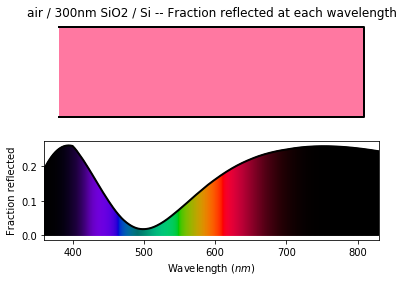

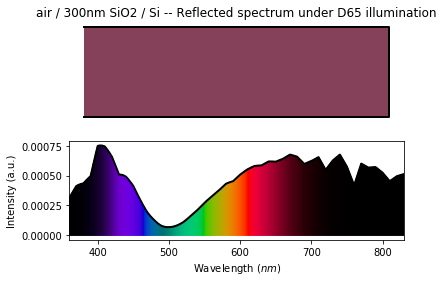

In [8]:
%%time
# Crystalline silicon refractive index. Data from Palik via
# http://refractiveindex.info, I haven't checked it, but this is just for
# demonstration purposes anyway.
Si_n_fn = get_ntotal_fn('Si')
# SiO2 refractive index (approximate): 1.46 regardless of wavelength
SiO2_n_fn = get_ntotal_fn('SiO2_2')
TiO2_n_fn=get_ntotal_fn("TiO2_2")
aSi_n_fn=get_ntotal_fn("Si")
# air refractive index
air_n_fn = get_ntotal_fn("Air")

n_fn_list = [air_n_fn, SiO2_n_fn, TiO2_n_fn, Si_n_fn]
d_list = [inf, 200, 50, inf]

th_0 = 0

# Print the colors, and show plots, for the special case of 300nm-thick SiO2

reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
illuminant = colorpy.illuminants.get_illuminant_D65()
spectrum = color.calc_spectrum(reflectances, illuminant)
color_dict = color.calc_color(spectrum)
print('air / 300nm SiO2 / Si --- rgb =', color_dict['rgb'], ', xyY =', color_dict['xyY'])
plt.figure()
color.plot_reflectances(reflectances,
                    title='air / 300nm SiO2 / Si -- '
                          'Fraction reflected at each wavelength')
plt.figure()
color.plot_spectrum(spectrum,
                    title='air / 300nm SiO2 / Si -- '
                          'Reflected spectrum under D65 illumination')

In [9]:
Si_n_fn(500)

array(4.293+0.045j)

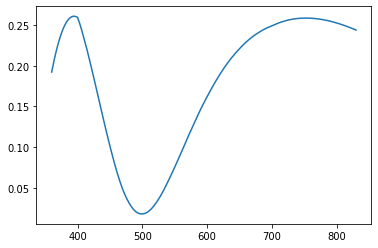

In [10]:
plt.plot(reflectances[:,0],reflectances[:,1])

## Caluclate absorption vs. depth

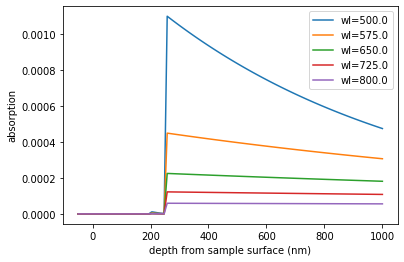

In [11]:
lam_vac_arr=np.linspace(500,800,5)
for lam_vac in lam_vac_arr:
    n_list = [np.asscalar(n_fn_list[i](lam_vac)) for i in range(len(n_fn_list))]
    coh_data=coh_tmm('s',n_list,d_list,th_0,lam_vac)
    zx=np.linspace(-50,1000,100)
    z_response=np.ones_like(zx)
    for i in range(zx.shape[0]):
        d_layer,d=find_in_structure_with_inf(d_list,zx[i])
        za=position_resolved(d_layer,d,coh_data)['absor']
        z_response[i]=za
    plt.plot(zx,z_response,label="wl=%s"%lam_vac)
plt.legend()
plt.xlabel("depth from sample surface (nm)")
plt.ylabel("absorption")
plt.show()

## Calculate total absorption in each layer

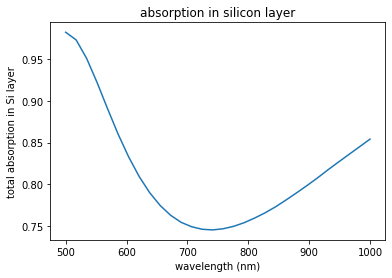

In [12]:
lam_vac_arr=np.linspace(500,1000,30)
abs_si=[]
index_of_si_layer=3
for lam_vac in lam_vac_arr:
    n_list = [np.asscalar(n_fn_list[i](lam_vac)) for i in range(len(n_fn_list))]
    coh_data=coh_tmm('s',n_list,d_list,th_0,lam_vac)
    result=absorp_in_each_layer(coh_data)
    abs_si.append(result[index_of_si_layer])

plt.plot(lam_vac_arr,abs_si)
plt.xlabel("wavelength (nm)")
plt.ylabel("total absorption in Si layer")
plt.title("absorption in silicon layer")
plt.show()

In [20]:
%%time
# Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
# integers 0-255) versus thickness of SiO2
max_SiO2_thickness = 300
SiO2_thickness_list = linspace(0,max_SiO2_thickness,num=80)
irgb_list = []
n_fn_list_2 = [air_n_fn, SiO2_n_fn, Si_n_fn]
for SiO2_d in SiO2_thickness_list:
    d_list = [inf, SiO2_d ,inf]
    reflectances_p = color.calc_reflectances(n_fn_list_2, d_list, th_0,pol='p')
    reflectances_s = color.calc_reflectances(n_fn_list_2, d_list, th_0,pol='s')
    reflectances_unp=(reflectances_p+reflectances_s)/2
    reflectances_unp[:,0]=reflectances_p[:,0]
    illuminant = colorpy.illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances_unp, illuminant)
    color_dict = color.calc_color(spectrum)
    irgb_list.append(colorpy.colormodels.irgb_string_from_irgb(color_dict['irgb']))

Wall time: 26.6 s


In [19]:
# Plot those colors
print('Making color vs SiO2 thickness graph. Compare to (for example)')
print('http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm')
colorpy.plots.color_tile_vs_1param_plot(SiO2_thickness_list,irgb_list,
                                        xlabel_name="SiO2 thickness (nm)",
                                       title_name="Air/SiO2/Si (nm)")

Making color vs SiO2 thickness graph. Compare to (for example)
http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm


AttributeError: module 'colorpy.plots' has no attribute 'color_tile_vs_1param_plot'

## Make two dimension plot

In [14]:
%%time
# Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
# integers 0-255) versus thickness of SiO2
max_inc_angle = 80
max_d=150
inc_angle = linspace(0,max_inc_angle,num=10)
SiO2_d_list=linspace(0,max_d,num=10)

irgb_list =[]
for i,ang in enumerate(inc_angle):
    for j,SiO2_d in enumerate(SiO2_d_list):
        d_list = [inf, SiO2_d, 50, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, ang/180*pi)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        color_string = colorpy.colormodels.irgb_string_from_irgb(color_dict['irgb'])
        irgb_list.append(color_string)
        
colorpy.plots.color_tile_vs_2param_plot(inc_angle,SiO2_d_list,irgb_list,
                                   xlabel_name="incident angle (pol-s)",
                                  ylabel_name="SiO2 thickness (nm)",
                                  title_name="Air/SiO2/Si color")
plt.tight_layout()
plt.savefig("color_tiles_demo.pdf")
plt.show()

AttributeError: module 'colorpy.plots' has no attribute 'color_tile_vs_2param_plot'

In [15]:
%%time
# Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
# integers 0-255) versus thickness of SiO2
max_inc_angle = 80
max_d=150
inc_angle = linspace(0,max_inc_angle,num=10)
SiO2_d_list=linspace(0,max_d,num=15)
TiO2_d_list=linspace(0,max_d,num=15)

irgb_list =[]
for i,TiO2_d in enumerate(TiO2_d_list):
    for j,SiO2_d in enumerate(SiO2_d_list):
        d_list = [inf, SiO2_d, TiO2_d,inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, 0/180*pi)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        color_string = colorpy.colormodels.irgb_string_from_irgb(color_dict['irgb'])
        irgb_list.append(color_string)
        
colorpy.plots.color_tile_vs_2param_plot(TiO2_d_list,SiO2_d_list,irgb_list,
                                   xlabel_name="TiO2 thickness (nm)",
                                  ylabel_name="SiO2 thickness (nm)",
                                  title_name="Air/SiO2/TiO2/Si color")
plt.savefig("color_tiles_demo.png")

AttributeError: module 'colorpy.plots' has no attribute 'color_tile_vs_2param_plot'

### Create chroma map

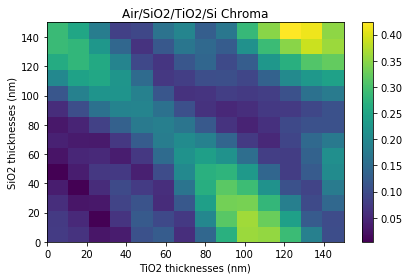

In [16]:
# convert the color string to hsv values
rgb_list=list(map(colorpy.colormodels.irgb_from_irgb_string,irgb_list))
chroma_list=list(map(chroma_from_irgb,rgb_list))
chroma_list=np.reshape(chroma_list,(TiO2_d_list.shape[0],SiO2_d_list.shape[0]))
plt.pcolormesh(TiO2_d_list,SiO2_d_list,chroma_list.T)
plt.colorbar()
plt.title("Air/SiO2/TiO2/Si Chroma")
plt.xlabel("TiO2 thicknesses (nm)")
plt.ylabel("SiO2 thicknesses (nm)")
plt.tight_layout()
plt.savefig("chroma.pdf")
plt.show()

### Create hue map

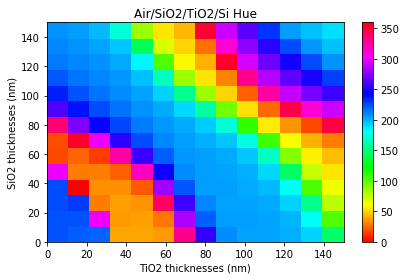

In [17]:
# convert the color string to hsv values
rgb_list=list(map(colorpy.colormodels.irgb_from_irgb_string,irgb_list))
hue_list=list(map(hue_from_irgb,rgb_list))
hue_list=np.reshape(hue_list,(TiO2_d_list.shape[0],SiO2_d_list.shape[0]))
plt.pcolormesh(TiO2_d_list,SiO2_d_list,hue_list.T,cmap='hsv',vmin=0,vmax=360)
plt.colorbar()
plt.title("Air/SiO2/TiO2/Si Hue")
plt.xlabel("TiO2 thicknesses (nm)")
plt.ylabel("SiO2 thicknesses (nm)")
plt.tight_layout()
plt.savefig("hue.pdf")
plt.show()